# Taylor Diagram: CMIP6 Precipitation Simulations

Make the Taylor Diagram for the precipitation data for each model used:
- CanESM5
- CMCC-CM2-SR5
- GFDL-ESM4
- HadGEM3-GC31-LL
- NorESM2-MM

##### References
Peter A. Rochford (2016) SkillMetrics: A Python package for calculating the skill of model predictions against observations, http://github.com/PeterRochford/SkillMetrics

Ben Farris (n.d.) Tutorial: Loading CMIP historical data, https://phaustin.github.io/climate_students_eoas/resources/tutorials/historical_data.html#tut-historical-data



In [1]:
# imports
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import fsspec
import nc_time_axis
import intake
import cartopy.crs as ccrs
import skill_metrics as sm
from pathlib import Path

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6

In [2]:
# Import dataset
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
cmipdf = col.df

## Taylor Diagram for Regridded Models

### Load the regridded data

The files used have been saved as NetCDF files and are opened here using Xarray's `open_dataset`. 

In [3]:
# Folder Directory
home_dir = Path.home()
out_folder = home_dir / "repos/atsc448/data"
out_folder2 = home_dir / "repos/atsc448/data/taylor_data"

In [4]:
can = xr.open_dataset(out_folder / "can_regrid.nc")
cmcc = xr.open_dataset(out_folder2 / "cmccPR.nc") # all models regridded to this resolution
gfdl = xr.open_dataset(out_folder / "gfdl_regrid.nc")
had = xr.open_dataset(out_folder / "had_regrid.nc")
nor = xr.open_dataset(out_folder / "nor_regrid.nc")
#cmcc_pr = model_down("cmccPR.nc", "CMIP.CMCC.CMCC-CM2-SR5.historical.Amon.gn", "Amon", "pr", "CMCC-CM2-SR5", "historical", ("1950","2010"))


## Select the data for project

For each model, select the longitude and latitude extents of region used in project and the years used in the analysis. Since CMCC-CM2-SR5 has not been regridded, it already contains the sliced data in its original NetCDF File. 

In [5]:
can_sel = can.sel(lon = slice(225, 310), lat = slice(0, 55), time = slice('1950', '2010'))
can_ds = can_sel.drop_vars(['dcpp_init_year'])

gfdl_sel = gfdl.sel(lon = slice(225, 310), lat = slice(0, 55), time = slice('1950', '2010'))
gfdl_ds = gfdl_sel.drop_vars(['dcpp_init_year'])

had_sel = had.sel(lon = slice(225, 310), lat = slice(0, 55), time = slice('1950', '2010'))
had_ds = had_sel.drop_vars(['dcpp_init_year'])

nor_sel = nor.sel(lon = slice(225, 310), lat = slice(0, 55), time = slice('1950', '2010'))
nor_ds = nor_sel.drop_vars(['dcpp_init_year'])


The filtered models will now be grouped by their years then meaned over them. Then they will be meaned over their region (the latitude and longitude values). The precipitation units are then converted from kg m-2 s-1 to mm yr-1 using 86400*365. 

In [6]:
# Code based on notebook by Ben Farris 
mean_precip_canesm = can_ds.groupby('time.year').mean('time').mean(['lon', 'lat'])*86400*365
mean_precip_cmcc = cmcc.groupby('time.year').mean('time').mean(['lon', 'lat'])*86400*365
mean_precip_gfdl = gfdl_ds.groupby('time.year').mean('time').mean(['lon', 'lat'])*86400*365
mean_precip_had = had_ds.groupby('time.year').mean('time').mean(['lon', 'lat'])*86400*365
mean_precip_nor = nor_ds.groupby('time.year').mean('time').mean(['lon', 'lat'])*86400*365

Set up the model by converting to a numpy array and flattening the array. Remove any NaN values because they will not allow the Taylor Diagram to run. 

In [7]:
# Set up models
# Code based on notebook by Ben Farris, "Tutorial: Loading CMIP historical data"

ref = mean_precip_canesm.mean('member_id').pr.to_numpy().flatten()
can = ref
cmcc = mean_precip_cmcc.mean('member_id').pr.to_numpy().flatten()
gfdl = mean_precip_gfdl.mean('member_id').pr.to_numpy().flatten()
had = mean_precip_had.mean('member_id').pr.to_numpy().flatten()
nor = mean_precip_nor.mean('member_id').pr.to_numpy().flatten()

# Remove NaN values
ref = ref[~np.isnan(ref)]
can = can[~np.isnan(can)]
cmcc = cmcc[~np.isnan(cmcc)]
gfdl = gfdl[~np.isnan(gfdl)]
had = had[~np.isnan(had)]
nor = nor[~np.isnan(nor)]

### Plot the Taylor Diagram

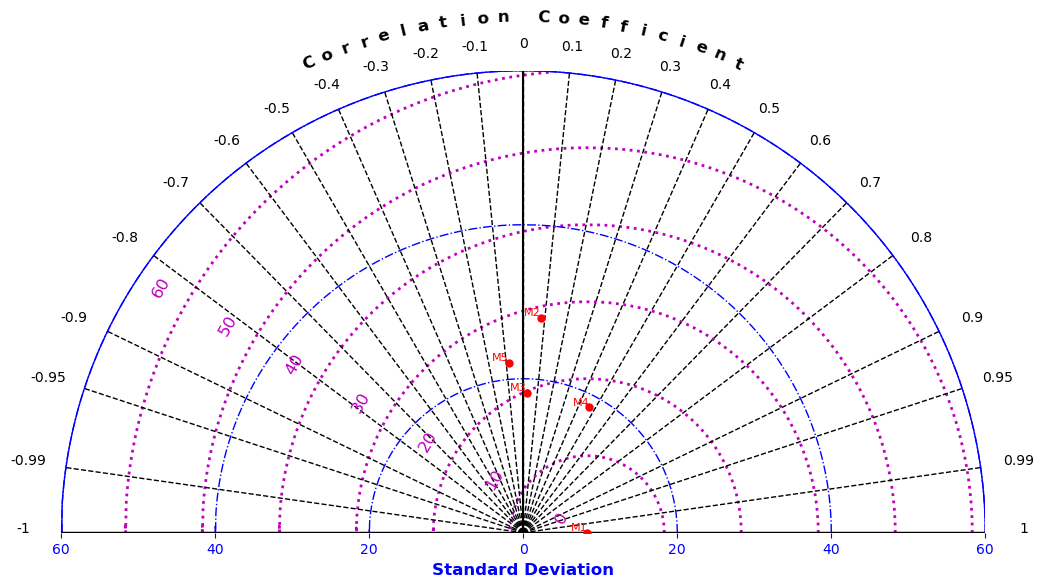

In [8]:
# Taylor Diagram
# Code here is taken from the notebook by Ben Farris, "Tutorial: Loading CMIP historical data"
#  and edited to be used for my models. 
# Code is based off of taylor7.py from Peter Rochford: SkillMetrics/Examples/taylor7.py

data = {'ref': ref, 'can': can, 'cmcc': cmcc, 'gfdl':gfdl, 'had':had, 'nor':nor}

taylor_stats1 = sm.taylor_statistics(data['can'], data['ref'], 'data')
taylor_stats2 = sm.taylor_statistics(data['cmcc'], data['ref'], 'data')
taylor_stats3 = sm.taylor_statistics(data['gfdl'], data['ref'], 'data')
taylor_stats4 = sm.taylor_statistics(data['had'], data['ref'], 'data')
taylor_stats5 = sm.taylor_statistics(data['nor'], data['ref'], 'data')

sdev = np.array([taylor_stats1['sdev'][0], taylor_stats1['sdev'][1], 
                 taylor_stats2['sdev'][1], taylor_stats3['sdev'][1],
                 taylor_stats4['sdev'][1], taylor_stats5['sdev'][1]])

crmsd = np.array([taylor_stats1['crmsd'][0], taylor_stats1['crmsd'][1], 
                  taylor_stats2['crmsd'][1], taylor_stats3['crmsd'][1],
                  taylor_stats4['crmsd'][1], taylor_stats5['crmsd'][1]])

ccoef = np.array([taylor_stats1['ccoef'][0], taylor_stats1['ccoef'][1], 
                  taylor_stats2['ccoef'][1], taylor_stats3['ccoef'][1],
                  taylor_stats4['ccoef'][1], taylor_stats5['ccoef'][1]])

# crmsd = coordinate root mean square deviation

# Specify labels for points in a cell array (M1 for model prediction 1,
# etc.). Note that a label needs to be specified for the reference even
# though it is not used.
label = ['Non-Dimensional Observation', 'M1', 'M2', 'M3', 'M4', 'M5']

'''
Produce the Taylor diagram

Display the data points for correlations that vary from -1 to 1 (2
panels). Label the points and change the axis options for SDEV, CRMSD,
and CCOEF. Increase the upper limit for the SDEV axis and rotate the
CRMSD contour labels (counter-clockwise from x-axis). Exchange color and
line style choices for SDEV, CRMSD, and CCOEFF variables to show effect.
Increase the line width of all lines.

For an exhaustive list of options to customize your diagram, 
please call the function at a Python command line:
>> taylor_diagram
'''
sm.taylor_diagram(sdev,crmsd,ccoef,
                  numberPanels = 2,
                  markerLabel = label, markerLabelColor = 'r',
                  tickRMS = range(0,90,10), tickRMSangle = 150.0,
                  colRMS = 'm', styleRMS = ':', widthRMS = 2.0, 
                  titleRMS = 'off',
                  tickSTD = range(0, 80, 20), axismax = 60.0,
                  colSTD = 'b', styleSTD = '-.', widthSTD = 1.0,
                  colCOR = 'k', styleCOR = '--', widthCOR = 1.0)